**Importing packages**

In [1]:
import spacy
import os
import glob
import codecs
import pandas as pd
from pandas import DataFrame
import numpy as np
from tqdm import tqdm
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
%matplotlib notebook
import seaborn as sns
%matplotlib inline
nlp = spacy.load('en')

**Loading documents**

In [2]:
#Loading general file of reverse data
reverse_list = pd.read_csv('case_reversed.csv')

#the text files have to be in folder "cases" in the same folder of the code
fileDir = os.path.dirname(os.path.realpath('__file__'))
files = glob.glob('cases/*.txt')
files = files[2000:2200] #Sampling 200 cases (1000 takes huge time)

#reverse list    
caseid = list(reverse_list['caseid'])
year = sorted([column[6:10] for column in files])
files = [x for _,x in sorted(zip(year,files))]

#loading text data from different files
TextData = list(range(len(files)))
for f in range(len(files)):
    with codecs.open(files[f], 'r', encoding='utf-8') as myfile:
        TextData[f] = myfile.read()

    files[f] = files[f].replace("cases/","").replace(".txt","")
    
count = 0
reverse = list(range(len(files)))
fcaseid = [column[5:] for column in files] 
for m in range(len(reverse_list)):
    for o in range(len(fcaseid)):
        if reverse_list.at[m,'caseid'] == fcaseid[o]:
            reverse[count] = reverse_list.at[m,'case_reversed']
            count = count + 1

new_reverse_list = DataFrame({'caseid':fcaseid, 'year':year, 'reverse_result':reverse, 'trigrams':year})

**Spliting into sentences, words, & letters**

In [3]:
S = list(range(len(files)))
freq = [[0]*3 for _ in range(len(files))]

for n in tqdm(range(0,len(files))):
     doc = nlp(TextData[n])   

     S[n] = list(doc.sents)
     freq[n][0] = len(list(doc.sents))

     freq[n][1] = len(doc.text.split())

     freq[n][2] = len(doc.text)

100%|██████████| 200/200 [01:41<00:00,  1.37it/s]


**Histograms of the different segments of the corpus**

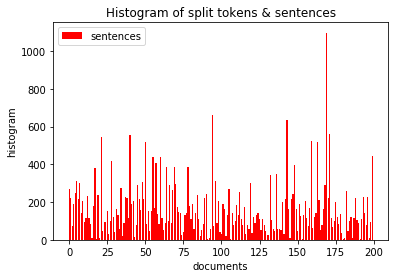

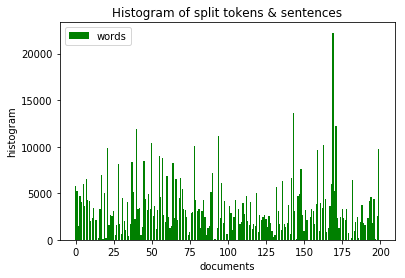

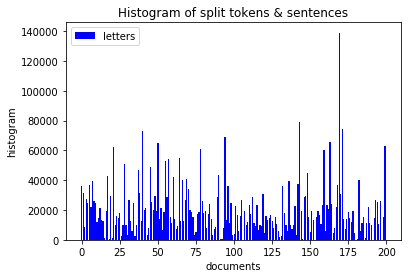

In [4]:
ID = list(range(len(files)))

plt.bar(ID,[column[0] for column in freq], label='sentences',color='r')
plt.xlabel('documents')
plt.ylabel('histogram')
plt.title('Histogram of split tokens & sentences')
plt.legend()
plt.show()

plt.bar(ID,[column[1] for column in freq], label='words',color='g')
plt.xlabel('documents')
plt.ylabel('histogram')
plt.title('Histogram of split tokens & sentences')
plt.legend()
plt.show()

plt.bar(ID,[column[2] for column in freq], label='letters',color='b')
plt.xlabel('documents')
plt.ylabel('histogram')
plt.title('Histogram of split tokens & sentences')
plt.legend()
plt.show()

**parts of speech (POS) tags & frequency by year**

100%|██████████| 200/200 [00:00<00:00, 429.78it/s]


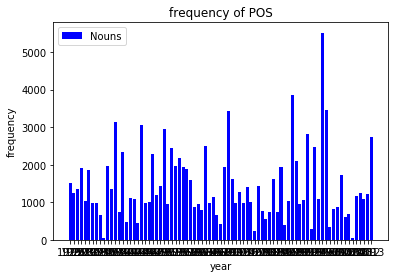

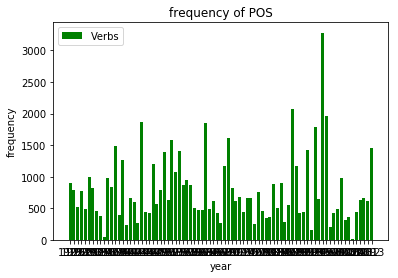

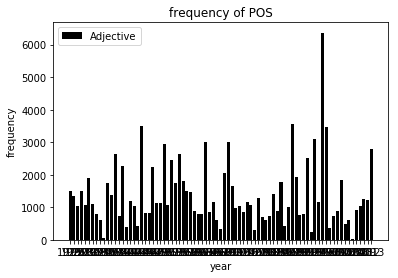

In [5]:
Ncount = [0]*len(files)
Vcount = [0]*len(files)
Acount = [0]*len(files)

for g in tqdm(range(len(files))):
    for i in range(len(S[g])):
        doc = S[g][i]

        for token in doc:
            if token.pos_[0] == 'N':
                Ncount[g] = Ncount[g] + 1
            elif token.pos_[0] == 'V':
                Vcount[g] = Vcount[g] + 1
            elif token.pos_[0] == 'A':
                Acount[g] = Acount[g] + 1
  
plt.bar(year,Ncount, label='Nouns',color='b')
plt.xlabel('year')
plt.ylabel('frequency')
plt.title('frequency of POS')
plt.legend()
plt.show()

plt.bar(year,Vcount, label='Verbs',color='g')
plt.xlabel('year')
plt.ylabel('frequency')
plt.title('frequency of POS')
plt.legend()
plt.show()

plt.bar(year,Acount, label='Adjective',color='k')
plt.xlabel('year')
plt.ylabel('frequency')
plt.title('frequency of POS')
plt.legend()
plt.show()

**Normalize your corpus. and feature set of all trigrams that end in a noun**

In [6]:
#Normalizing the text data
S_clean = list(S)
stemmer = SnowballStemmer('english') 
stoplist = stopwords.words('english') 

for k in tqdm(range(len(S))):
    for l in range(len(S[k])):
        part = S[k][l]
      #Lemmatizing AND removing punctuations AND stop words and stemming
        e = ""
        for token in part:
            if token.pos_ != 'PUNCT' and token.lemma_ != '-pron-' and token.lemma_ != '-PRON-' and not token.is_stop:
                stemmedtoken = stemmer.stem(token.lemma_)
                e = e + " " + stemmedtoken
        S_clean[k][l] = nlp(e)

100%|██████████| 200/200 [04:10<00:00,  1.63s/it]


In [7]:
#N-grams
NoneType = type(None)
df_data = new_reverse_list
WordNumber = max([column[1] for column in freq]) #The highest possible number of words

for g in tqdm(range(len(S_clean))):
    ngram = list(range(WordNumber))
    count = 0
    for i in range(len(S_clean[g])):
        doc = S_clean[g][i]    
        skiped_doc = doc[2:]
        for token in skiped_doc:
            if token.pos_ == 'NOUN':
                sample = str(S_clean[g][i][token.i-3:token.i])
                if sample != '':
                    ngram[count] = sample
                    sample = ''
                    count = count + 1

    ngram = ngram[:count]                
    df_data.at[g,'trigrams']= ngram

100%|██████████| 200/200 [00:01<00:00, 146.59it/s]


**Make a dataframe with at least 1000 features (frequencies over trigrams ending in a noun). Standardize the features to variance one while maintaining sparsity.** 

In [8]:
frequencies = Counter()

for tokens in df_data['trigrams']:
    frequencies.update(tokens)

cleaned_freqs = []
for tokens in df_data['trigrams']:
    cleaned_freqs.append(Counter(tokens))
    
features = pd.DataFrame(cleaned_freqs)
features.fillna(0,inplace=True)

**Link the dataframe to the outcome reverse. Create a training set and test set. Train a LogisticRegression model with default parameters to predict reversal. Compute accuracy and F1 for the prediction in the training set and in the test set.**

In [9]:
X = features
Y = df_data['reverse_result']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression: {:.2f}'.format(logreg.score(X_test, Y_test)))
print('F1 score of logistic regression: {:.2f}'.format(f1_score(Y_test, Y_pred, average='weighted')))

Accuracy of logistic regression: 0.57
F1 score of logistic regression: 0.42


**Use GridSearchCV() to choose hyperparameters: L1 vs L2 penalty, and regularization parameter C. Report the best model parameters and score. Report the ROC Curve and AUC.**

hpyerparameters: (L1 vs L2 penality) & C  {'C': 0.1, 'penalty': 'l1'}
AOC score 0.94


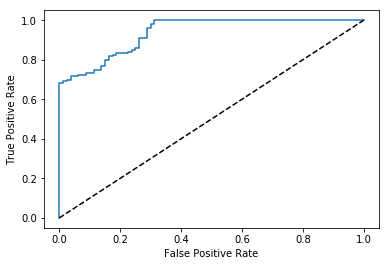

In [10]:
# Grid Search
y = df_data['reverse_result']
y_scores = logreg.decision_function(features)

# Grid search cross validation
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,Y_train)

print("hpyerparameters: (L1 vs L2 penality) & C ",logreg_cv.best_params_)

#ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#Text(0, 0.5, 'True Positive Rate')

#AUC
print('AOC score {:.2f}'.format(roc_auc_score(y, y_scores)))

**Make a new dataframe where each sentence (of each case) is treated as a separate document. Compute vader compound sentiment scores for each sentence and report the top 10 highest- and lowest-sentiment sentences.**

In [11]:
#combining all raw sentences
Slength = 0
count = 0

for t in range(len(S)):
    Slength = Slength + len(S[t])
allsen = list(range(Slength))

for l in range(len(S)):
    for k in range(len(S[l])):
        allsen[count] = str(S[l][k]) 
        count = count + 1
    
allsentences = DataFrame({'sentences': allsen})


sentiment = SentimentIntensityAnalyzer()
for x in tqdm(range(len(allsentences))):
    snip = str(allsentences.at[x,'sentences'])
    polarity = sentiment.polarity_scores(snip)
    allsentences.at[x,'sentiment'] = polarity['compound']
    
PS = [x for _,x in sorted(zip(allsentences['sentiment'],allsentences['sentences']), reverse = True)]  

print('Highest sentiment score \n',"\n".join(PS[:10]),"\n")
print('Lowest sentiment score \n',"\n".join(PS[-10:]),"\n")

100%|██████████| 32934/32934 [00:04<00:00, 6701.00it/s]

Highest sentiment score 
  but fact enjoy procedur protect capsul term process mean state depriv individu freedom associ forc support union accord procedur reason assur depriv necessari prevent individu take free ride entiti want support provid servic collect bargain repres 

 but court remark compel employe financi support collect bargain repres impact first amend interest requir help financ union collect bargain agent think interfer way employe 's freedom associ advanc idea refrain see fit 

 but author special court exercis independ counsel particular respect scope independ 218 counsel 's investig far great qualit differ role feder judg vis vis grand juri 

 true power termin trust ordinarili equival power revok instanc trust instrument convey properti life trust convey re termin effect termin nullifi grant return trust properti grantor 

 local 16 request appelle negoti respect certain work claim longshoreman work includ load barg own appelle appelle bargain local m-271 result agre

**Use TfidfVectorizer to compute tf-idf frequencies for each sentence, and then compute cosine similarities between all sentences.**

In [12]:
# tf-idf vectorizer
tfidf = TfidfVectorizer(min_df=0.01, 
                        max_df=0.9,                        
                        stop_words='english',
                        use_idf=True)
X_tfidf = tfidf.fit_transform(allsentences['sentences'])

#cosine similarities
tcsim = cosine_similarity(X_tfidf)

**Report example pairs of very similar sentences and very dissimilar sentences**

In [13]:
numberofpairs = 2

mini = 0
maxi = -1
aloha = np.sort(tcsim, axis=None)     
[ra,ca] = np.where(tcsim == aloha[maxi])
[ri,ci] = np.where(tcsim == aloha[mini])

while len(ri)<numberofpairs and len(ri)<numberofpairs:
    maxi = maxi-1
    mini = mini+1
    [ra,ca] = np.where(tcsim == aloha[maxi])
    [ri,ri] = np.where(tcsim == aloha[mini])

for x in range(numberofpairs):
    print('similar sentences are:',allsentences.at[ra[x],'sentences'],
          '\n','and','\n',allsentences.at[ca[x],'sentences'])
    print('\nunsimilar sentences are:',allsentences.at[ri[x],'sentences'],
          '\n','and','\n',allsentences.at[ci[x],'sentences'])

similar sentences are:  under amend california requir submit approv administr state plan provid implement mainten enforc nation ambient air qualiti standard 3 includ necessari land use transport control 
 
 and 
  under amend california requir submit approv administr state plan provid implement mainten enforc nation ambient air qualiti standard 3 includ necessari land use transport control 


unsimilar sentences are:    sneed circuit judg 
 and 
  this proceed grow numer petit review certain regul environment protect agenc 

similar sentences are:  after conclud attain requir ambient air qualiti standard photochem oxid carbon monoxid defer 1977 necessari technolog altern avail 11 administr 's plan contempl thing reduct gasolin sell los angel san francisco sacramento valley san joaquin valley san diego region oper state california inspect mainten program design reduc emiss automobil limit impos state use motorcycl institut state oxid catalyst retrofit program control dri clean solvent v

**Use k-means clustering to assign the sentences into 20 clusters. List 5 example sentences from each cluster.** 

In [14]:
# K-means clustering
clusters = 20
km = KMeans(n_clusters=clusters,n_jobs=-1)
km.fit(X_tfidf)
doc_clusters = km.labels_.tolist()
allsentences['cluster'] = doc_clusters

for y in range(clusters):
    print("cluster ",y)
    cluster = allsentences[allsentences['cluster']==y]['sentences']
    print(cluster[:5])

cluster  0
360                              idaho would 256 97 s.ct
915                                    idaho 303 72 s.ct
975     32 l.ed.2d 705 1972 observ section 1983 uniqu...
978     when congress pass predecessor section 1983 i...
981                               idaho 240 - 42 92 s.ct
Name: sentences, dtype: object
cluster  1
178     santa cruz co. v. labor board 303 u.s. 453 46...
193        see pike v. bruce church 397 u.s. 137 90 s.ct
195     bibb v. navajo freight line inc. 359 u.s. 520...
203               campbel v. hussey 368 u.s. 297 82 s.ct
219     see steward machin co. v. davi 301 u.s. 548 5...
Name: sentences, dtype: object
cluster  2
145     have power regul air pollut administr continu...
155     this regul includ power direct state enact la...
156     the state builder road maker traffic law lice...
200     nor administr mere insist area control air po...
239     1816 enforc recogn supremaci valid feder law ...
Name: sentences, dtype: object
cluster  3
2      p